In [6]:
import deblend
import om10
import desc.slrealizer
import warnings
warnings.filterwarnings("ignore")

In [7]:
db = om10.DB()
db.select_random(maglim=23.3,area=18000.0,IQ=0.75)
db.paint(synthetic=True)
realizer = desc.slrealizer.SLRealizer(catalog=db, observation="../../../data/twinkles_observation_history.csv")

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems
OM10: selection yields 2813 lenses


In [8]:
%matplotlib inline
%pylab inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

Populating the interactive namespace from numpy and matplotlib


In [9]:
# Choose a good lens system, with large imsep and 4 images:
                      
wide = db.sample[np.where(db.sample['IMSEP'] > 1.0)]
print "Number of lenses with image separation > 1.0 arcsec = ",len(wide)

wide_quads = wide[np.where(wide['NIMG'] == 4)]
print "Number of these with 4 images = ",len(wide_quads)

bright_wide_quads = wide[np.where(wide_quads['MAGI'] < 22)]
print "Number of these with i3 < 22 = ",len(bright_wide_quads)

db.sample = bright_wide_quads    
                      
k = db.sample[0]['LENSID']

Number of lenses with image separation > 1.0 arcsec =  1921
Number of these with 4 images =  302
Number of these with i3 < 22 =  141


OM10: Extracted OM10 lens number 59330266:
 LENSID  FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
-------- -------- ---- ----- ... ------------- ------------- -------------
59330266        0    2 1.374 ...         23.63 23.5242061854          99.0
multiplication factor :  2.89820591325e-06
39058.0339037
PSF_sigma:  0.730282
multiplication factor :  39058.0339037
1398.6716384
PSF_sigma:  0.730282
multiplication factor :  1398.6716384
(array([[  4.04567055e+08,   1.98629259e+11,   9.96786404e+13,
          5.10581230e+16],
       [  1.91283588e+11,   9.39250739e+13,   4.71400386e+16,
          2.41490896e+19],
       [  9.28273459e+13,   4.55870015e+16,   2.28827763e+19,
          1.17240357e+22],
       [  4.61741501e+16,   2.26796664e+19,   1.13860913e+22,
          5.83460344e+24]]), 'hello')
#####################BEFORE DEBLEND PLOT LENSES##################################
moment_matrix:  [[  4.04567055e+08   1.98629259e+11   9.96786404e+13   5.10581230e+16]
 [  1.

TypeError: Invalid dimensions for image data

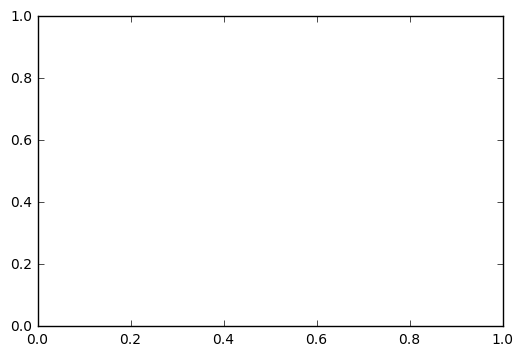

In [10]:
realizer.deblend(lensID=k, null_deblend=True, debug=False)